<a href="https://colab.research.google.com/github/wenko99/Standalone_DDL/blob/master/Lec03/Lec03_IrisClassification_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Open in Colab이 열리지 않으면 [여기](https://drive.google.com/open?id=1psUMkHwv-Aba1O4iPGwuNMxYRseeus6X)를 클릭하세요

In [0]:
import numpy as np
from sklearn import datasets
iris = datasets.load_iris()
iris_data = iris.data
iris_labels = iris.target

import pandas as pd

df = pd.DataFrame(iris_data)
df2 = pd.DataFrame(iris_labels)
df = pd.concat([df, df2], axis=1, sort=False)
df.columns = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Classes']

np.random.seed(7)
df = df.reindex(np.random.permutation(df.index))

iris_data = df.iloc[:, :4].values
iris_labels = df.iloc[:, 4].values

# Data Preprocessing

Set train_x and train_y for training data

Set test_x and test_y for testing data

In [0]:
n_train_data = 135

train_x = iris_data[ : n_train_data]
train_y = iris_labels[ : n_train_data]
test_x = iris_data[n_train_data : ]
test_y = iris_labels[n_train_data : ]

# Score Function


$ f(X) = WX + B$

$W.shape = (3,4)$

$X.shape = (4, )$

$B.shape = (3, )$

$f(X).shape = (3, )$

In [0]:
def score_function(X, weight, bias):
    return weight.dot(X) + bias

#SVM Loss

##$L_{i} = \underset{j\neq y_i}\sum max(0 \ ,\ s_j - s_{y_i} + \triangle )$

##$L = {1\over N}\underset{i=1}{\overset{N}\sum} L_{i}$

In [0]:
def svm_loss(scores, y_i):
    loss = np.maximum(0 , scores - scores[y_i] + 1)
    loss[y_i] = 0
    return np.sum(loss)

#Softmax Function and Cross-entropy Loss

##$p_{i} = { e^{s_{y_i} - max(s) }\over\underset{j}\sum{ e^ {s_{j} - max(s)}  } }$

##$L_{i} = -\ log( p_{i}) $

##$L = {1\over N}\underset{i=1}{\overset{N}\sum} L_{i}$

In [0]:
def softmax(scores):
    exps = np.exp(scores - np.max(scores))
    return exps / np.sum(exps)

In [0]:
def cross_entropy_loss(scores, y_i):
    return - np.log(softmax(scores)[y_i])

#L2 Regularization

###$R(W) = \underset{k}\sum\underset{l}\sum {W_{kl}}^2$

In [0]:
def l2_reg(W):
    return np.sum(np.square(W))

#Numeric Gradient Check

##$f'(W) = {f(W + h) - f(W - h) \over 2h}$

In [0]:
def numeric_grad_check(W, B, loss_fun, h, lmb):
    grad_w = np.zeros(W.shape)
    grad_b = np.zeros(B.shape)
    
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            w1 = W.copy()
            w2 = W.copy()
            w1[i][j] += h
            w2[i][j] -= h
            for k in range(len(train_x)):
                grad_w[i][j] += ( loss_fun(score_function(train_x[k], w1, B), train_y[k]) - loss_fun(score_function(train_x[k], w2, B), train_y[k]) ) /  (2*h)
    grad_w /= len(train_x)
    grad_w += lmb * 2 * W
    
    for i in range(B.shape[0]):
        b1 = B.copy()
        b2 = B.copy()
        b1[i] += h
        b2[i] -= h
        for j in range(len(train_x)):
            grad_b[i] += ( loss_fun(score_function(train_x[j], W, b1), train_y[j]) - loss_fun(score_function(train_x[j], W, b2), train_y[j]) ) /  (2*h)
    grad_b /= n_train_data
    
    return grad_w, grad_b

# Train


###$Gradient \ Update\ (SVM)$
##$\begin{cases}
{\partial L_{i} \over \partial w_{y_i} } = - \underset{j \ne y_i}\sum 1(s_j - s_{y_i} + 1 > 0) \cdot x_{i}^{T} \\
{\partial L_{i} \over \partial w_{j} } = 1(s_j - s_{y_i} + 1 > 0) \cdot x_{i}^{T}
\end{cases}
$

##$\begin{cases}
{\partial L_{i} \over \partial b_{y_i} } = - \underset{j \ne y_i}\sum 1(s_j - s_{y_i} + 1 > 0)\\
{\partial L_{i} \over \partial b_{j} } = 1(s_j - s_{y_i} + 1 > 0) 
\end{cases}
$

###$Gradient \ Update\ (Cross-Entropy)$
##$\begin{cases}
{\partial L_{i} \over \partial w_{y_i} } = - x_i + p_i \cdot x_{i}^{T} \\
{\partial L_{i} \over \partial w_{j} } = p_i \cdot x_{i}^{T}
\end{cases}
$

##$\begin{cases}
{\partial L_{i} \over \partial b_{y_i} } = - 1+ p_i  \\
{\partial L_{i} \over \partial b_{j} } = p_i
\end{cases}
$

##수정한 부분:



```
    if loss_fun is svm_loss:
        for elem in j:
            if scores[elem] - scores[y] + 1 > 0:
                grad_w[y, ] -= x
                grad_w[elem, ] += x
                grad_b[y, ] -= 1
                grad_b[elem, ] += 1
```

위의 수식이 잘 보이지 않으면 colab에서 열어주세요.

svm에 대한 수식을 잘못 적어놓기도 했고, $ s_j - s_{y_i} + 1 $을 매 $s_j$ 마다 구해주지 않아서 numreic gradient와 차이가 있었던 것 같습니다.  현재는 모두 수정하였으니, 참고해주세요. :)

In [0]:
def gradient_update(weight, bias, loss_fun, i, x, y):
    grad_w = np.zeros(weight.shape)
    grad_b = np.zeros(bias.shape)
    
    scores = score_function(x, weight, bias)
    loss = loss_fun(scores, y)
    
    j = [0, 1, 2]
    j.remove(y)
    if loss_fun is svm_loss:
        for elem in j:
            if scores[elem] - scores[y] + 1 > 0:
                grad_w[y, ] -= x
                grad_w[elem, ] += x
                grad_b[y, ] -= 1
                grad_b[elem, ] += 1
    elif loss_fun is cross_entropy_loss:
        grad_w += softmax(scores).reshape(3,1) * train_x[i]
        grad_w[train_y[i], ] -= train_x[i]
        grad_b += softmax(scores)
        grad_b[train_y[i], ] -= 1
    
    return grad_w, grad_b 

In [0]:
def train(weight, bias, lr, lmb, loss_fun):
    
    train_loss = 0
    grad_w = np.zeros(weight.shape)
    grad_b = np.zeros(bias.shape)
    acc = 0
    
    for i in range(135):
        scores = score_function(train_x[i], weight, bias)
        loss = loss_fun(scores, train_y[i])
        train_loss += loss
        
        update_w, update_b = gradient_update(weight, bias, loss_fun, i, train_x[i], train_y[i])
        grad_w += update_w
        grad_b += update_b
        
        if train_y[i] == scores.argmax():
            acc += 1
    
    train_loss /= n_train_data
    train_loss += lmb * l2_reg(weight)
    
    grad_w /= n_train_data
    grad_w += 2 * lmb * weight
    grad_b /= n_train_data
    
    #grad_w, grad_b = numeric_grad_check(weight, bias, loss_fun, h=0.00001, lmb=lmb)
    
    weight -= lr * grad_w
    bias -= lr * grad_b
    
    result = {}
    result['weight'] = weight
    result['accuracy'] = acc / n_train_data
    result['train_loss'] = train_loss
    result['gradient_w'] = grad_w
    result['bias'] = bias
    result['gradient_b'] = grad_b
    
    return result

# Test

- calculate accuracy for test set

In [0]:
def validation(weight, bias, loss_fun):
    
    test_loss = 0
    acc = 0
    
    for i in range(15):
        scores = score_function(test_x[i], weight, bias)
        
        test_loss += loss_fun(scores, test_y[i])
        
        if test_y[i] == scores.argmax():
            acc += 1
                
    test_loss /= len(test_x)
    
    result = {}
    result['test_loss'] = test_loss
    result['accuracy'] = acc / len(test_x)
    
    return result

# Experience

In [0]:
np.random.seed(123)
Weight = np.random.uniform(-2, 2, (3,4))
Bias = np.random.uniform(-5, 5, (3,))

grad_wn, grad_bn = numeric_grad_check(Weight, Bias, svm_loss, 0.00001, lmb=0.01)
result = train(Weight, Bias, lr=0.05, lmb=0.01, loss_fun=svm_loss)
grad_wa = result['gradient_w']
grad_ba = result['gradient_b']


print(grad_wa[0][0])
print(grad_wn[0][0])
print(grad_ba[0])
print(grad_bn[0])

0.46016197929227354
0.4601619792923889
-0.014814814814814815
-0.014814814808168302


In [0]:
np.random.seed(123)
weight = np.random.uniform(-2, 2, (3,4))
bias = np.random.uniform(-5, 5, (3,))
lr = 0.005
lmb = 0.001
epoch = 1000
loss_fun = svm_loss

hyperp = {}
hyperp['lr'] = lr
hyperp['epoch'] = epoch
hyperp['lambda'] = lmb
hyperp['loss_fun'] = loss_fun

result = {}
result['train_loss'] = []
result['epoch'] = []
result['gradient'] = []
result['accuracy'] = []
result['val_loss'] = []
result['val_epoch'] = []

for i in range(epoch):
    traind = train(weight, bias, lr, lmb, loss_fun)
    result['train_loss'].append(traind['train_loss'])
    result['epoch'].append(i)
    result['gradient'].append(traind['gradient_w'])
    result['accuracy'].append(traind['accuracy'])
    weight, bias = traind['weight'], traind['bias']
    
    if i%10 == 0:
        val = validation(weight, bias, loss_fun)
        result['val_loss'].append(val['test_loss'])
        result['val_epoch'].append(i)

print("Accuaracy for train set is {0:2.2%}".format(traind['accuracy']))

print("Accuaracy for validation set is {0:2.2%}".format(val['accuracy']))

Accuaracy for train set is 87.41%
Accuaracy for validation set is 86.67%


# Plot Graph

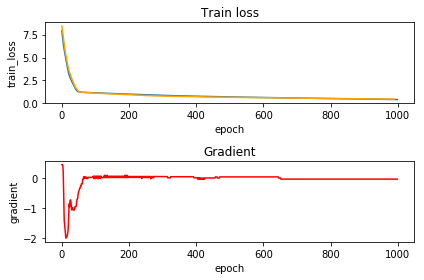

learning rate is 0.005 and epoch is 1000
regularization rate is 0.001 and loss function is <function svm_loss at 0x7f007d937bf8>
Accuracy For Train Set is 87.41%
Accuracy For Test Set is 86.67%


In [0]:
import matplotlib.pyplot as plt
fig = plt.figure()

plt.subplot(2,1,1)
plt.title('Train loss')
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.plot(result['epoch'], result['train_loss'])
plt.plot(result['val_epoch'], result['val_loss'], color = 'orange')

plt.subplot(2,1,2)
plt.title('Gradient')
plt.xlabel('epoch')
plt.ylabel('gradient')
plt.plot(result['epoch'], [result['gradient'][i][0][0] for i in range(epoch)], color = 'red')

fig.tight_layout()
plt.show()

print("learning rate is {0} and epoch is {1}".format(hyperp['lr'], hyperp['epoch']))
print("regularization rate is {0} and loss function is {1}".format(hyperp['lambda'], hyperp['loss_fun']))
print("Accuracy For Train Set is {0:2.2%}".format(result['accuracy'][-1]))
print("Accuracy For Test Set is {0:2.2%}".format(val['accuracy']))